<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Построим модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

## Подготовка

In [1]:
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score, GridSearchCV , train_test_split 
from sklearn.metrics import make_scorer, mean_squared_error
import numpy as np
from sklearn.dummy import DummyRegressor

In [2]:
df_taxi = pd.read_csv('/datasets/taxi.csv', parse_dates=[0], index_col=[0])
df_taxi.info()

<class 'pandas.core.frame.DataFrame'>

DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00

Data columns (total 1 columns):

 #   Column      Non-Null Count  Dtype

---  ------      --------------  -----

 0   num_orders  26496 non-null  int64

dtypes: int64(1)

memory usage: 414.0 KB


In [3]:
df_taxi.head(20)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17


In [4]:
df_taxi.tail(20)

,num_orders
datetime,
2018-08-31 20:40:00,16
2018-08-31 20:50:00,18
2018-08-31 21:00:00,24
2018-08-31 21:10:00,29
2018-08-31 21:20:00,23
2018-08-31 21:30:00,27
2018-08-31 21:40:00,29
2018-08-31 21:50:00,27
2018-08-31 22:00:00,34


In [5]:
def rows_check(df_taxi):
    for column in df_taxi.columns:
        print('Уникальные значения столбца', column)
        print(df_taxi[column].unique())
    print('Количество пропусков в каждом столбце')    
    print(df_taxi.isna().mean())

In [6]:
print(rows_check(df_taxi))

Уникальные значения столбца num_orders

[  9  14  28  20  32  21   7   5  17  12  19  25  22   8   6   4  10  13

   2   3   0   1  11  15  16  23  18  33  24  26  30  38  34  42  31  27

  36  29  35  56  37  40  39  45  49  58  68  43  53  44  41  52  46  57

  47  64  61  50  48  55  62  54  71  78 119  99  51  60  87  90  94  82

  80  91  76  66  65  98  81  95  67]

Количество пропусков в каждом столбце

num_orders    0.0

dtype: float64

None


In [7]:
df_taxi.index.value_counts()

2018-03-09 22:10:00    1
2018-07-20 13:00:00    1
2018-04-07 16:50:00    1
2018-05-13 22:40:00    1
2018-03-06 22:30:00    1
                      ..
2018-06-22 17:10:00    1
2018-06-06 20:00:00    1
2018-04-20 04:30:00    1
2018-04-04 07:20:00    1
2018-06-26 15:40:00    1
Name: datetime, Length: 26496, dtype: int64

In [8]:
df_taxi.index.duplicated()

array([False, False, False, ..., False, False, False])

In [9]:
print(df_taxi.head(20))

                     num_orders

datetime                       

2018-03-01 00:00:00           9

2018-03-01 00:10:00          14

2018-03-01 00:20:00          28

2018-03-01 00:30:00          20

2018-03-01 00:40:00          32

2018-03-01 00:50:00          21

2018-03-01 01:00:00           7

2018-03-01 01:10:00           5

2018-03-01 01:20:00          17

2018-03-01 01:30:00          12

2018-03-01 01:40:00          19

2018-03-01 01:50:00          25

2018-03-01 02:00:00          22

2018-03-01 02:10:00          12

2018-03-01 02:20:00          19

2018-03-01 02:30:00           8

2018-03-01 02:40:00           6

2018-03-01 02:50:00           4

2018-03-01 03:00:00           8

2018-03-01 03:10:00          17


In [10]:
df_taxi = df_taxi.sort_index()
print(df_taxi.index.is_monotonic)

True


In [11]:
# ресемплируем данные по 1 часу
df_taxi = df_taxi.resample('1H').sum()

# Итог первого этапа

Даны заказы такси с марта по август 2018 года. Мы изменили тип данных Datetime с object на datetime64 и установили индекс таблицы равным столбцу Datetime. Проверили на наличие пропусков, на монотонность и ресемплировали данные по часу.

## Анализ

In [12]:
df_taxi.info()

<class 'pandas.core.frame.DataFrame'>

DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00

Freq: H

Data columns (total 1 columns):

 #   Column      Non-Null Count  Dtype

---  ------      --------------  -----

 0   num_orders  4416 non-null   int64

dtypes: int64(1)

memory usage: 69.0 KB


In [13]:
df_taxi_copy = df_taxi.copy()
df_taxi_copy["rolling_mean"] = df_taxi_copy["num_orders"].rolling(20).mean()
df_taxi_copy["rolling_std"] = df_taxi_copy["num_orders"].rolling(20).std()

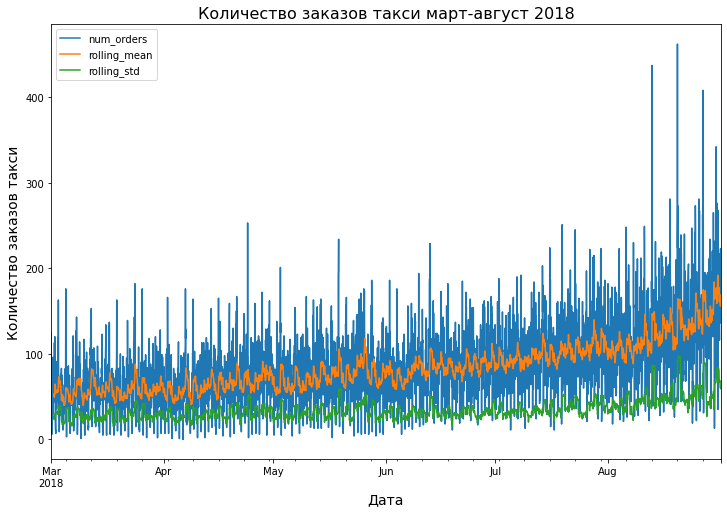

In [14]:
# построим график временного рядя
df_taxi_copy.plot(figsize=(12,8))
plt.xlabel('Дата', fontsize=14)
plt.ylabel('Количество заказов такси', fontsize=14)
plt.title('Количество заказов такси март-август 2018', fontsize=16)
plt.legend()
plt.show()

In [15]:
df_taxi.info()

<class 'pandas.core.frame.DataFrame'>

DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00

Freq: H

Data columns (total 1 columns):

 #   Column      Non-Null Count  Dtype

---  ------      --------------  -----

 0   num_orders  4416 non-null   int64

dtypes: int64(1)

memory usage: 69.0 KB


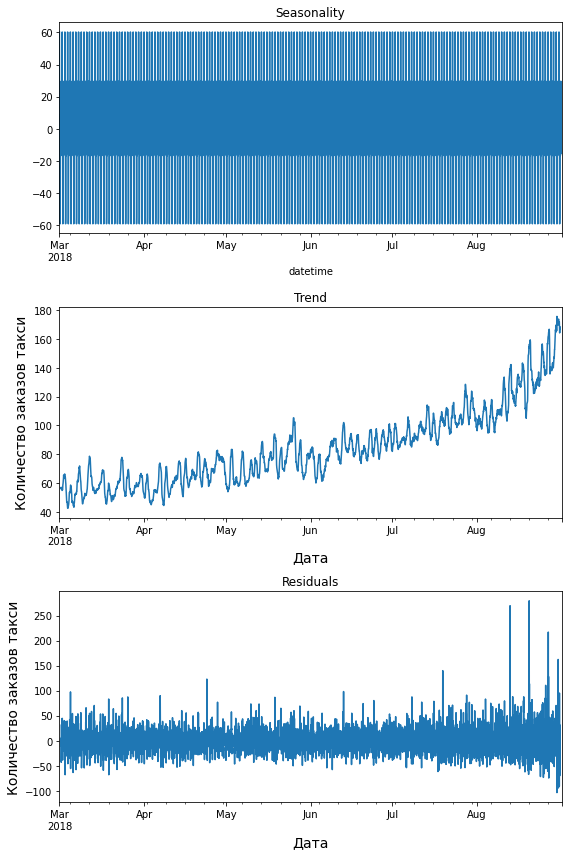

In [16]:
decomposed = seasonal_decompose(df_taxi)

plt.figure(figsize=(8, 12))

plt.subplot(311)

decomposed.seasonal.plot(ax=plt.gca())

# Чтобы график корректно отобразился, указываем его
# оси ax, равными plt.gca() (англ. get current axis,
# получить текущие оси)

plt.title('Seasonality')
plt.subplot(312)
plt.xlabel('Дата', fontsize=14)
plt.ylabel('Количество заказов такси', fontsize=14)
decomposed.trend.plot(ax=plt.gca())

plt.title('Trend')
plt.xlabel('Дата', fontsize=14)
plt.ylabel('Количество заказов такси', fontsize=14)
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())

plt.title('Residuals')
plt.xlabel('Дата', fontsize=14)
plt.ylabel('Количество заказов такси', fontsize=14) 
plt.tight_layout()

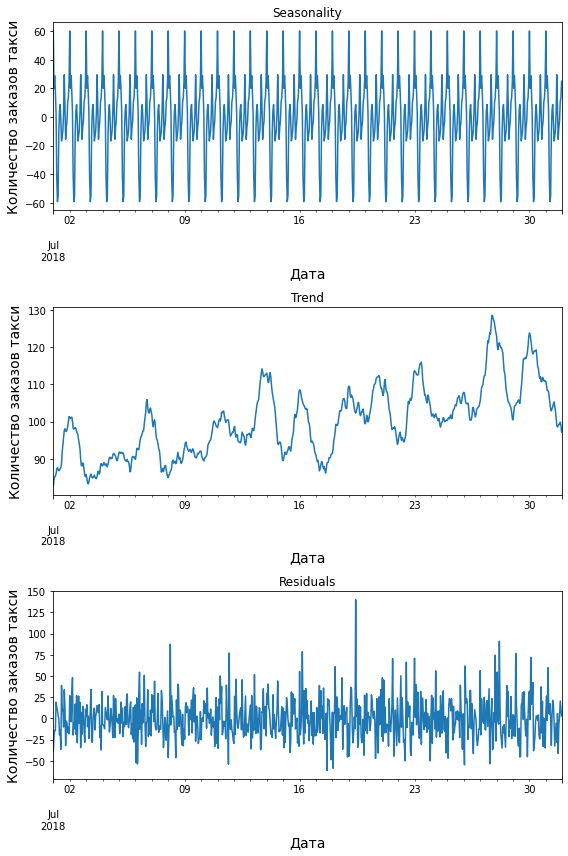

In [17]:
# построим график сезонной составляющей за июль
plt.figure(figsize=(8, 12))
plt.subplot(311)
decomposed.seasonal['2018-07-01':'2018-07-31'].plot(ax=plt.gca())
plt.title('Seasonality')
plt.xlabel('Дата', fontsize=14)
plt.ylabel('Количество заказов такси', fontsize=14)
plt.subplot(312)
decomposed.trend['2018-07-01':'2018-07-31'].plot(ax=plt.gca())


plt.title('Trend')
plt.xlabel('Дата', fontsize=14)
plt.ylabel('Количество заказов такси', fontsize=14)
plt.subplot(313)
decomposed.resid['2018-07-01':'2018-07-31'].plot(ax=plt.gca())


plt.title('Residuals')
plt.xlabel('Дата', fontsize=14)
plt.ylabel('Количество заказов такси', fontsize=14)
plt.tight_layout()


Можно заметить, что количество заказов растет на протяжении месяца

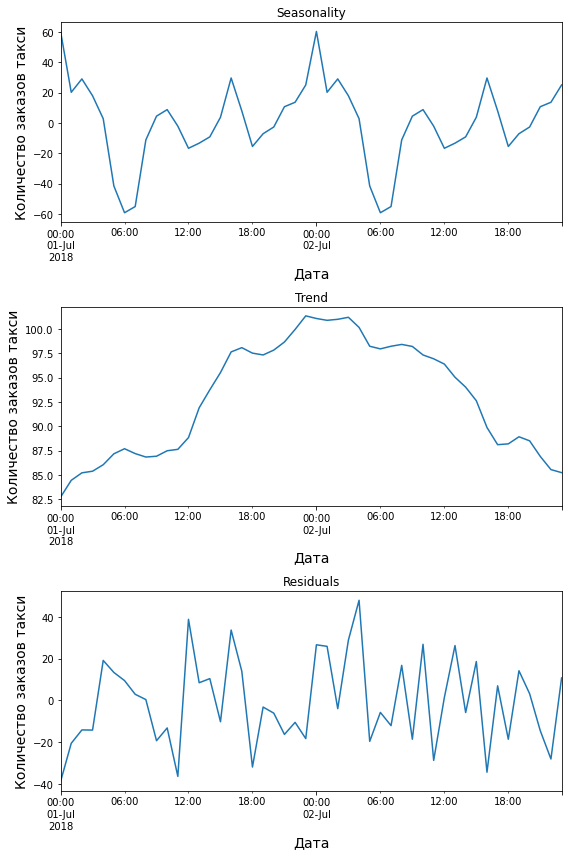

In [18]:
# построим график сезонной составляющей за двое суток июля
plt.figure(figsize=(8, 12))
plt.subplot(311)
decomposed.seasonal['2018-07-01':'2018-07-02'].plot(ax=plt.gca())
plt.title('Seasonality')
plt.xlabel('Дата', fontsize=14)
plt.ylabel('Количество заказов такси', fontsize=14)
plt.subplot(312)
decomposed.trend['2018-07-01':'2018-07-02'].plot(ax=plt.gca())


plt.title('Trend')
plt.xlabel('Дата', fontsize=14)
plt.ylabel('Количество заказов такси', fontsize=14)
plt.subplot(313)
decomposed.resid['2018-07-01':'2018-07-02'].plot(ax=plt.gca())


plt.title('Residuals')
plt.xlabel('Дата', fontsize=14)
plt.ylabel('Количество заказов такси', fontsize=14)
plt.tight_layout()


Заметно, что пик заказов приходится на полночь, а наименьшее количество заказов - утром

Проведем тест Дики-Фуллера

In [19]:
result = adfuller(df_taxi['num_orders'])
print('ADF Statistic: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))
print('Critical values:')
for key, value in result[4].items():
  print('\t {}: {}'.format(key, value))

ADF Statistic: -3.0689242890279558

p-value: 0.028940051402612906

Critical values:

	 1%: -3.431842162413052

	 5%: -2.8621993540813637

	 10%: -2.567120978470452


Так как p-value - меньше порогового значения 0.05, то можно сделать вывод, что ряд стационарный.

Проверим стационарность временного ряда.

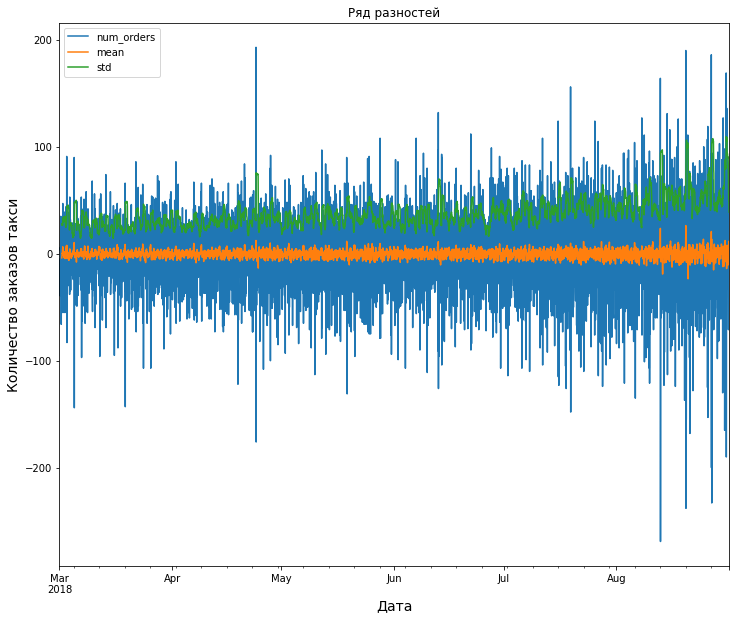

In [20]:
df_taxi_1 = df_taxi - df_taxi.shift()
df_taxi_1['mean'] = df_taxi_1['num_orders'].rolling(15).mean()
df_taxi_1['std'] = df_taxi_1['num_orders'].rolling(15).std()
df_taxi_1.plot(figsize=(12,10))
plt.title('Ряд разностей')
plt.xlabel('Дата', fontsize=14)
plt.ylabel('Количество заказов такси', fontsize=14)
plt.show()

Среднее значение ряда и стандартное отклонение изменяются минимально - можно сделать вывод, что ряд стационарный

Создадим признаки для горизонта прогнозирования в 1 шаг:

In [21]:
def make_features(df_taxi, max_lag, rolling_mean_size):
    df_taxi['day'] = df_taxi.index.day
    df_taxi['dayofweek'] = df_taxi.index.dayofweek
    df_taxi['hour'] = df_taxi.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        df_taxi['lag_{}'.format(lag)] = df_taxi['num_orders'].shift(lag)
        df_taxi['rolling_mean'] = df_taxi['num_orders'].shift().rolling(rolling_mean_size).mean()

make_features(df_taxi, 24, 10)
print(df_taxi.head())

                     num_orders  day  dayofweek  hour  lag_1  rolling_mean  \

datetime                                                                     

2018-03-01 00:00:00         124    1          3     3    NaN           NaN   

2018-03-01 01:00:00          85    1          3     3  124.0           NaN   

2018-03-01 02:00:00          71    1          3     3   85.0           NaN   

2018-03-01 03:00:00          66    1          3     3   71.0           NaN   

2018-03-01 04:00:00          43    1          3     3   66.0           NaN   



                     lag_2  lag_3  lag_4  lag_5  ...  lag_15  lag_16  lag_17  \

datetime                                         ...                           

2018-03-01 00:00:00    NaN    NaN    NaN    NaN  ...     NaN     NaN     NaN   

2018-03-01 01:00:00    NaN    NaN    NaN    NaN  ...     NaN     NaN     NaN   

2018-03-01 02:00:00  124.0    NaN    NaN    NaN  ...     NaN     NaN     NaN   

2018-03-01 03:00:00   85.0  124.0    NaN

In [22]:
# удалим пропуски

df_taxi.dropna(inplace=True)

In [23]:
df_taxi.head()

,num_orders,day,dayofweek,hour,lag_1,rolling_mean,lag_2,lag_3,lag_4,lag_5,...,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-02 00:00:00,90,2,4,4,58.0,61.7,113.0,66.0,61.0,45.0,...,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0
2018-03-02 01:00:00,120,2,4,4,90.0,65.9,58.0,113.0,66.0,61.0,...,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0
2018-03-02 02:00:00,75,2,4,4,120.0,71.3,90.0,58.0,113.0,66.0,...,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0
2018-03-02 03:00:00,64,2,4,4,75.0,74.5,120.0,90.0,58.0,113.0,...,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0
2018-03-02 04:00:00,20,2,4,4,64.0,76.5,75.0,120.0,90.0,58.0,...,32.0,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0


In [24]:
df_taxi.info()

<class 'pandas.core.frame.DataFrame'>

DatetimeIndex: 4392 entries, 2018-03-02 00:00:00 to 2018-08-31 23:00:00

Freq: H

Data columns (total 29 columns):

 #   Column        Non-Null Count  Dtype  

---  ------        --------------  -----  

 0   num_orders    4392 non-null   int64  

 1   day           4392 non-null   int64  

 2   dayofweek     4392 non-null   int64  

 3   hour          4392 non-null   int64  

 4   lag_1         4392 non-null   float64

 5   rolling_mean  4392 non-null   float64

 6   lag_2         4392 non-null   float64

 7   lag_3         4392 non-null   float64

 8   lag_4         4392 non-null   float64

 9   lag_5         4392 non-null   float64

 10  lag_6         4392 non-null   float64

 11  lag_7         4392 non-null   float64

 12  lag_8         4392 non-null   float64

 13  lag_9         4392 non-null   float64

 14  lag_10        4392 non-null   float64

 15  lag_11        4392 non-null   float64

 16  lag_12        4392 non-null   float64

 17  lag_

# Итог второго этапа

В этом разделе мы проанализировали графики временного ряда(по всем данным, месяцу и 2м дням), выявили тренды на увеличение количества заказов с течением времени, а также то, что максимум заказов приходится на полночь, а минимум на 6 утра. Проверили на стационарность временной ряд. Создали календарные признаки для месяца, дня, дня недели, часа и отстающие признаки, а также скользящее среднее. После удаления признаков получили таблицу готовую для построения моделей.

## Обучение

In [25]:
train, test = train_test_split(df_taxi, shuffle=False, test_size=0.1)
train = train.dropna()

features_train = train.drop('num_orders', axis=1)
target_train = train['num_orders']
 
features_test = test.drop('num_orders', axis=1)
target_test = test['num_orders']

In [26]:
# проверим размер выборок
display(train.shape)
display(test.shape)
# проверим корректность деления
print(train.index.min(), train.index.max())
print(test.index.min(), test.index.max())

(3952, 29)

(440, 29)

2018-03-02 00:00:00 2018-08-13 15:00:00

2018-08-13 16:00:00 2018-08-31 23:00:00


# Модель линейной регрессии

In [28]:
%%time

model = LinearRegression()
time_split = TimeSeriesSplit(n_splits=3)
#определяю RMSE модели с помощью кросс-валидации
regression_cv_score = (cross_val_score(model, features_train, target_train, cv=time_split, 
                                                scoring='neg_root_mean_squared_error').mean()*-1)
print('Среднее качество модели линейной регрессии на кросс-валидации:', regression_cv_score)

Среднее качество модели линейной регрессии на кросс-валидации: 27.73800323931358

CPU times: user 172 ms, sys: 360 ms, total: 532 ms

Wall time: 493 ms


# Модель случайного леса

In [30]:
model = RandomForestRegressor(random_state=42)
parameters = {"max_depth": [1,10],"n_estimators":[100,150,10]}

RF_grid = GridSearchCV(model,parameters,cv = time_split, verbose=10, n_jobs=-1)
RF_grid.fit(features_train, target_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits

[CV 1/3; 1/6] START max_depth=1, n_estimators=100...............................

[CV 1/3; 1/6] END .............max_depth=1, n_estimators=100; total time=   0.2s

[CV 2/3; 1/6] START max_depth=1, n_estimators=100...............................

[CV 2/3; 1/6] END .............max_depth=1, n_estimators=100; total time=   0.3s

[CV 3/3; 1/6] START max_depth=1, n_estimators=100...............................

[CV 3/3; 1/6] END .............max_depth=1, n_estimators=100; total time=   0.4s

[CV 1/3; 2/6] START max_depth=1, n_estimators=150...............................

[CV 1/3; 2/6] END .............max_depth=1, n_estimators=150; total time=   0.3s

[CV 2/3; 2/6] START max_depth=1, n_estimators=150...............................

[CV 2/3; 2/6] END .............max_depth=1, n_estimators=150; total time=   0.4s

[CV 3/3; 2/6] START max_depth=1, n_estimators=150...............................

[CV 3/3; 2/6] END .............max_de

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
             estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [1, 10], 'n_estimators': [100, 150, 10]},
             verbose=10)

# Модель LightGBM

In [31]:
param_grid = {'n_estimators': [100, 500, 1000], 'num_leaves': [n for n in range(20, 300, 20)]}

In [77]:
model = lgb.LGBMRegressor(random_state=12345)

testing_model=GridSearchCV(estimator=model,
                          param_grid = param_grid,
                          scoring='neg_root_mean_squared_error',
                          cv=time_split,
                          verbose=10, n_jobs=-1)

testing_model.fit(features_train, target_train)
display('Лучшие параметры модели:', testing_model.best_params_)
display('Лучшая метрика модели:', testing_model.best_score_*-1)

Fitting 3 folds for each of 42 candidates, totalling 126 fits

[CV 1/3; 1/42] START n_estimators=100, num_leaves=20............................

[CV 1/3; 1/42] END ..........n_estimators=100, num_leaves=20; total time=   1.3s

[CV 2/3; 1/42] START n_estimators=100, num_leaves=20............................

[CV 2/3; 1/42] END ..........n_estimators=100, num_leaves=20; total time=   1.0s

[CV 3/3; 1/42] START n_estimators=100, num_leaves=20............................

[CV 3/3; 1/42] END ..........n_estimators=100, num_leaves=20; total time=   1.8s

[CV 1/3; 2/42] START n_estimators=100, num_leaves=40............................

[CV 1/3; 2/42] END ..........n_estimators=100, num_leaves=40; total time=  10.3s

[CV 2/3; 2/42] START n_estimators=100, num_leaves=40............................

[CV 2/3; 2/42] END ..........n_estimators=100, num_leaves=40; total time=   9.7s

[CV 3/3; 2/42] START n_estimators=100, num_leaves=40............................

[CV 3/3; 2/42] END ..........n_esti

'Лучшие параметры модели:'

{'n_estimators': 100, 'num_leaves': 20}

'Лучшая метрика модели:'

27.164973910650332

# Итог третьего этапа

Проверили несколько моделей: линейную регрессию, случайный лес и LightGBM. При подборе гиперпараметров методом GridSearchCV модель LightGBM показала наилучшее значение RMSE - 27.164. 

## Тестирование

Протестируем выбранную модель на тестовой выборке 

In [32]:
model = lgb.LGBMRegressor(random_state=12345, n_estimators = 100  , num_leaves = 20 )
model.fit(features_train, target_train)
predictions_test = model.predict(features_test)
rmse = mean_squared_error(target_test, predictions_test)**0.5
print('RMSE лучшей модели на тестовой выборке:', rmse)

RMSE лучшей модели на тестовой выборке: 41.35978912286963


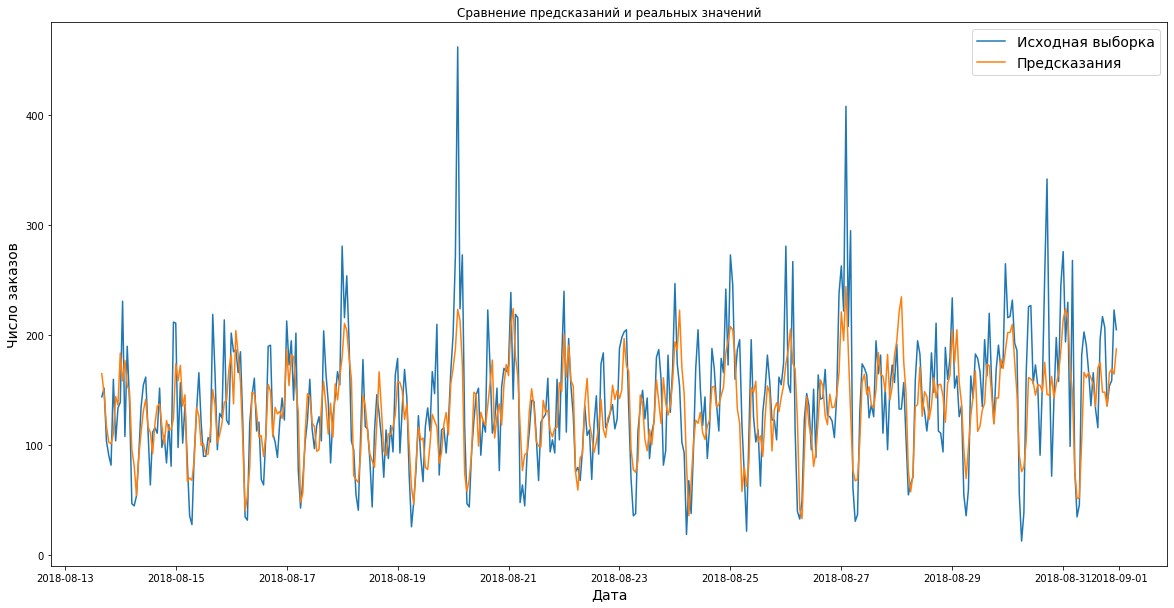

In [33]:
predictions_test = pd.Series(predictions_test, index=target_test.index)
plt.figure(figsize=(20,10))
plt.title('Сравнение предсказаний и реальных значений')
plt.xlabel('Дата', fontsize=14)
plt.ylabel('Число заказов',fontsize=14)
plt.plot(target_test, label='Исходная выборка')
plt.plot(predictions_test, label='Предсказания')
plt.legend(fontsize=14)
plt.show()

Показатель RMSE на тестовой выборке удовлетворяет условию задачи. По графику видим, что модель имеет тренд на адекватные предсказания, но с повышением общего количества заказов за день не справляется и предсказывает хуже.

# Проверка модели на адекватность

In [34]:
dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(features_train, target_train)
predictions_dummy = dummy_regr.predict(features_test)
rmse_dummy = mean_squared_error(target_test, predictions_dummy)**0.5
print('RMSE константной модели на тестовой выборке:', rmse_dummy)

RMSE константной модели на тестовой выборке: 84.68768287118466


# Общий вывод

1) В первую очередь мы ознакомились с данными, обработали пропуски, проверили на мотонность, ресемплировали данные по часу, изменили тип данных Datetime с object на datetime64 и установили индекс таблицы равным столбцу Datetime. 

2)  На данном этапе мы проанализировали графики временного ряда (по всем данным, месяцу и 2м дням), выявили тренды на увеличение количества заказов с течением времени, а также то, что максимум заказов приходится на полночь, а минимум на 6 утра. Проверили на стационарность временной ряд. Создали календарные признаки для дня, дня недели, часа и отстающие признаки, а также скользящее среднее. После удаления признаков получили таблицу готовую для построения моделей.

3)  На этапе обучения моделей мы проверили несколько моделей: линейную регрессию, случайный лес и LightGBM. При подборе гиперпараметров методом GridSearchCV модель LightGBM показала наилучшее значение RMSE - 27.164.

4)  В заключительном этапе мы проверили выбранную модель на тестовой выборке и получили лучшее значение RMSE - 41.359. В сравнении с константной моделью, RMSE которой равно 84.687 - наша модель показала себя намного лучше. 